<a href="https://colab.research.google.com/github/AprilV/CSC3061/blob/master/APML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download the csv file from github
% rm -r ForDownloadOnly/
!git clone https://github.com/wsgdrfz/ForDownloadOnly.git
!ls

rm: cannot remove 'ForDownloadOnly/': No such file or directory
Cloning into 'ForDownloadOnly'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 10), reused 40 (delta 10), pack-reused 0
Unpacking objects: 100% (40/40), done.
ForDownloadOnly  sample_data


In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random
import math
import scipy.stats
from tabulate import tabulate
import pandas as pd
import csv
from scipy.stats import truncnorm
from scipy.stats import norm
import scipy. integrate as integrate

## Q.4 A ﬁrst Gibbs sampler

In [0]:
# compute p(t | s,y)
def p_tGsy_win(s1, s2, t_sigma):
    sample = np.random.normal(s1-s2, t_sigma)
    if sample > 0:
        return sample
    else:
        return 0

def p_tGsy_lose(s1, s2, t_sigma):
    sample = np.random.normal(s1-s2, t_sigma)
    if sample < 0:
        return sample
    else:
        return 0

# compute p(s | t,y)
def p_sGty(s_mean, s_sigma, t, t_sigma):
    M = np.mat([1, -1])
    sGty_sigma = (s_sigma.getI() + M.getT()*(1/t_sigma)*M).getI()
    sGty_mean = sGty_sigma*(s_sigma.getI()*s_mean + M.getT()*(1/t_sigma)*t)
    #print(s_mean, s_sigma)
    return np.random.multivariate_normal(np.squeeze(np.asarray(sGty_mean)), sGty_sigma),
              sGty_sigma[0,0],sGty_sigma[1,1]


In [0]:
# Gibbs sampling
def GibbsSampling(s_mean, s_sigma, t_sigma, K=1000, win=True):
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    # Initialization
    s1[0] = 200
    s2[0] = 100
    t[0] = 50 # s1[0] - s2[0]

    if win==True:
        for tau in range(K-1):
            t[tau+1] = p_tGsy_win(s1[tau], s2[tau], t_sigma)
            #print(t)
            s, sigma_s1, sigma_s2 = p_sGty(s_mean, s_sigma, t[tau+1], t_sigma)
            s1[tau+1] = s[0]
            s2[tau+1] = s[1]
        return s1, s2, t

    if win==False:
        for tau in range(K-1):
            t[tau+1] = p_tGsy_lose(s1[tau], s2[tau], t_sigma)
            #print(t)
            s, sigma_s1, sigma_s2 = p_sGty(s_mean, s_sigma, t[tau+1], t_sigma)
            s1[tau+1] = s[0]
            s2[tau+1] = s[1]
        return s1, s2, t

Test Gibbs Sampling

Updated mean of s1,s2,t:
27.15233619670456 23.041006532695015 4.2860422352293135


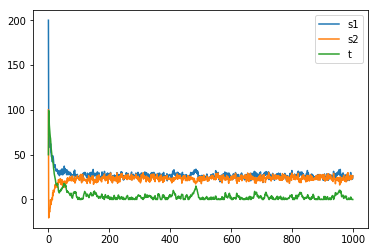

In [0]:
mu = 25 # initial mean of s1 and s2
var = 25/3 # initial variance of s1 and s2
s_mean = np.mat([[mu], [mu]])
s_sigma = np.mat([[var, 0], [0, var]])
t_sigma = 1
K = 1000 # number of samples
s1, s2, t = GibbsSampling(s_mean, s_sigma, t_sigma, K, win=True) 
print("Updated mean of s1,s2,t:")
print(s1.mean(),s2.mean(),t.mean())

def plotAllSamples(s1, s2, t):
    plt.plot(s1, label='s1')
    plt.plot(s2, label='s2')
    plt.plot(t, label= 't')
    plt.legend(loc='upper right')
    plt.show()

plotAllSamples(s1, s2, t)

### Calculate marginal parameters

In [0]:
def calcu_marg_para(s1, s2, t, K):
    # stationary samples
    burn_in = 100 
    s1_sta= np.array(s1[burn_in :]).reshape(K-burn_in,1)
    s2_sta= np.array(s2[burn_in:]).reshape(K-burn_in,1)
    t_sta = np.array(t [burn_in:]).reshape(K-burn_in,1)

    all_stable = np.concatenate((s1_sta,s2_sta,t_sta),axis=1) 
    # all the stable samples s1,s2,t
    samples_mean=np.mean(all_stable,axis=0) # mean
    # print(samples_mean,"\n")
    samples_conv=np.cov(all_stable.T) # covariance  
    # marginalization
    mu_marg  = samples_mean
    cov_marg = samples_conv
    # t_mu_marg   = samples_mean[-1]
    # t_cov_marg  = samples_conv[-1,-1]
    return mu_marg,cov_marg

# plot the samples and fitted Gaussian
def plotSampleGaussian(mu_marg, cov_marg, K):
    burn_in = 100 
    s1_sta= np.array(s1[burn_in :]).reshape(K-burn_in,1)
    s2_sta= np.array(s2[burn_in:]).reshape(K-burn_in,1)
    t_sta = np.array(t [burn_in:]).reshape(K-burn_in,1)

    s1_mu = mu_marg[0]
    s1_sigma = cov_marg[0][0]
    s2_mu = mu_marg[1]
    s2_sigma = cov_marg[1][1]

    xv = np.linspace(0,50,K-burn_in)
    plt.hist(s1_sta, bins=150, density=True)
    plt.plot(xv, 1/np.sqrt(2*np.pi*s1_sigma)*np.exp(-((xv-s1_mu)**2)/2/s1_sigma), label='s1')
    plt.legend(loc='upper right')
    plt.show()
    plt.hist(s2_sta, bins=150, density=True)
    plt.plot(xv, 1/np.sqrt(2*np.pi*s2_sigma)*np.exp(-((xv-s2_mu)**2)/2/s2_sigma), label='s2')
    plt.legend(loc='upper right')
    plt.show()

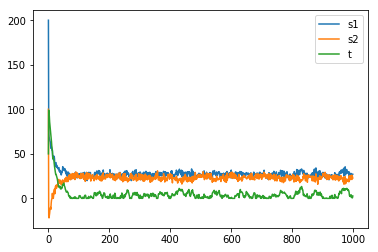

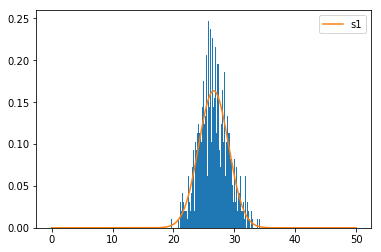

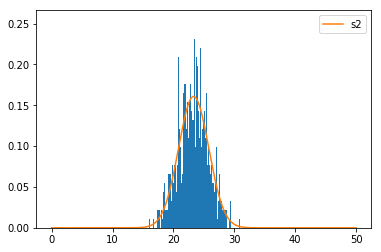

In [0]:
# find reasonable K
K = 1000
s1, s2,t = GibbsSampling(s_mean, s_sigma, t_sigma, K, win=True)
plotAllSamples(s1, s2, t)

mu_marg_Gibbs, cov_marg_Gibbs = calcu_marg_para(s1, s2, t, K)
plotSampleGaussian(mu_marg_Gibbs, cov_marg_Gibbs, K)

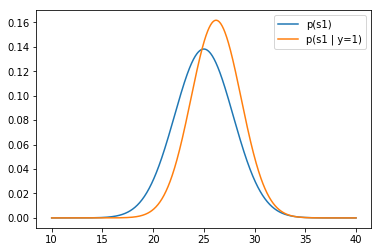

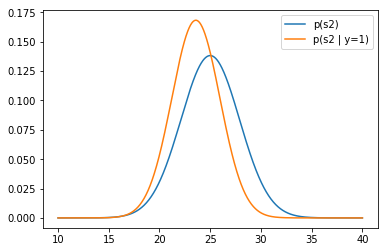

In [0]:
# Compare the prior p(s1) with the fitted Gaussian posterior p(s1 | y=1)
s1_mu = mu_marg_Gibbs[0]
s1_sigma = cov_marg_Gibbs[0][0]
s2_mu = mu_marg_Gibbs[1]
s2_sigma = cov_marg_Gibbs[1][1]
burn_in = 100

xv = np.linspace(10,40,K-burn_in)
plt.plot(xv, 1/np.sqrt(2*np.pi*var)*np.exp(-((xv-mu)**2)/2/var), label='p(s1)')
plt.plot(xv, 1/np.sqrt(2*np.pi*s1_sigma)*np.exp(-((xv-s1_mu)**2)/2/s1_sigma), label='p(s1 | y=1)')
plt.legend(loc='upper right')
plt.show()
plt.plot(xv,1/np.sqrt(2*np.pi*var)*np.exp(-((xv-mu)**2)/2/var), label='p(s2)')
plt.plot(xv,1/np.sqrt(2*np.pi*s2_sigma)*np.exp(-((xv-s2_mu)**2)/2/s2_sigma),label='p(s2 | y=1)')
plt.legend(loc='upper right')
plt.show()

## Q.5&6 Using the model for predictions

In [0]:
def preprocessing_data(filename, useful_col): # attention: must follow the order of col!
    df = pd.read_csv(filename, header=0)
    total_games_number = df.shape[0]
    # Useful info: 
    df_selected = df[useful_col]
    # change the header 
    df_selected.columns = ["Team1","Team2","Score1","Score2"]
    # print(df_selected[:10])
    # get the result of games
    df_selected['result'] = df_selected["Score1"] - df_selected["Score2"]
    draw_num = df_selected[df_selected['result']==0].shape[0]
    df_nodraw = df_selected[df_selected['result']!=0]
    return df_selected, df_nodraw, draw_num

In [0]:
 ##One step match, just integrate the probability of P(y=1),if larger than 0.5 ,s1 win
def end2end_inference(mu_s1, var_s1, mu_s2, var_s2, t_sigma, K, win=True):
    s_mean = np.mat([[mu_s1], [mu_s2]])
    s_sigma = np.mat([[var_s1, 0], [0, var_s2]])
    s1, s2, t = GibbsSampling(s_mean, s_sigma, t_sigma, K, win)
    mu_marg, cov_marg = calcu_marg_para(s1,s2,t, K)
    #print("mean: ", mu_marg, "\ncovariance: \n", cov_marg)
    return mu_marg[0],mu_marg[1],cov_marg[0][0],cov_marg[1][1]
    

# def predict_y(mu_s1, mu_s2, sigma_s1, sigma_s2, t_sigma=1):
#     area=scipy.stats.norm(mu_s1-mu_s2, t_sigma+sigma_s1+sigma_s2).cdf(0)
#     return 1-area

def predict_y(mu_s1, mu_s2, sigma_s1, sigma_s2, t_sigma=1):
    # Only consider mu:
    if(mu_s1>mu_s2):
      return 1
    else:
      return -1

In [0]:
def run_games(games_df, t_sigma=1, K=1000):  #header ["Team1","Team2","Score1","Score2"]
    # Init Dataframe for skill
    all_teams = list(set(games_df["Team1"].tolist()+games_df["Team2"].tolist()))
    pd_skills = pd.DataFrame(columns=["TeamName","Mu","Sigma"], index=all_teams)
    pd_skills["TeamName"] = all_teams
    pd_skills["Mu"] = 25
    pd_skills["Sigma"] = 25/3
    right_pred = 0
    for index, row in games_df.iterrows():
        mu_s1 = pd_skills.loc[row["Team1"],"Mu"]
        sigma_s1 = pd_skills.loc[row["Team1"],"Sigma"]
        mu_s2 = pd_skills.loc[row["Team2"],"Mu"]
        sigma_s2 = pd_skills.loc[row["Team2"],"Sigma"]
        predict_result = predict_y(mu_s1, mu_s2, sigma_s1, sigma_s2)
        if(row['result']!=0):
            mu_s1_new, mu_s2_new, sigma_s1_new, sigma_s2_new = end2end_inference(mu_s1, 
                                                                                 sigma_s1, 
                                                                                 mu_s2, 
                                                                                 sigma_s2,
                                                                                 t_sigma,
                                                                                 K,
                                                                                 win=(row['result']>0))
            pd_skills.loc[row["Team1"],"Mu"] = mu_s1_new
            pd_skills.loc[row["Team1"],"Sigma"] = sigma_s1_new
            pd_skills.loc[row["Team2"],"Mu"] = mu_s2_new
            pd_skills.loc[row["Team2"],"Sigma"] = sigma_s2_new
            if(predict_result*row['result']>0):
              right_pred+=1
        else:
            # ==0
            pass
    pd_skill_sort = pd_skills.sort_values("Mu",ascending=False).reset_index(drop = True)
    return pd_skill_sort, right_pred/games_df.shape[0]


In [0]:
# Preprocessing
given_data = 'ForDownloadOnly/SerieA.csv'
dfA_useful, dfA_nodraw, draw_num = preprocessing_data(given_data, \
                                                      ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])

NameError: ignored

In [0]:
# Run Q6
skills_A, acc = run_games(dfA_nodraw)
print(acc)
skills_A

0.6580882352941176


,TeamName,Mu,Sigma
0,Napoli,25.848718,0.128310
1,Juventus,25.835482,0.203195
2,Milan,25.762442,0.190722
3,Atalanta,25.656417,0.141423
4,Inter,25.568043,0.132637
5,Torino,25.526396,0.152452
6,Roma,25.242860,0.104927
7,Lazio,25.135804,0.129734
8,Sampdoria,24.956041,0.112503
9,Empoli,24.822487,0.107826


In [0]:
from google.colab import files
def download_table_latex(filename, df):
    with open(filename, 'w') as tf:
        tf.write(df.to_latex())
    files.download(filename)

# download_table_latex('skill_A.tex',skills_A)

In [0]:
# shuffle dataset
dfA_shuffle = dfA_nodraw.reindex(np.random.permutation(dfA_nodraw.index))
skills_A_shuffle, acc_shuffle = run_games(dfA_shuffle)
print(acc_shuffle)
skills_A_shuffle

0.6397058823529411


,TeamName,Mu,Sigma
0,Juventus,25.948123,0.089440
1,Napoli,25.813244,0.128690
2,Milan,25.671123,0.133262
3,Roma,25.524165,0.127374
4,Torino,25.506247,0.159661
5,Atalanta,25.387199,0.159477
6,Inter,25.224480,0.121081
7,Lazio,25.144085,0.101783
8,Sampdoria,25.110757,0.109844
9,Bologna,24.856654,0.100074


In [0]:
# download_table_latex('skill_A_shuffle.tex',skills_A_shuffle)

## Q.8 Message-passing algorithm

In [0]:
class Message:
    #"Class representing messages to simplify Gaussian message -passing"
    def __init__(self , m, s):
        self.m = m
        self.s = s

    def __mul__(self , other):
    #"Product of Gaussians"
        s = 1/(1/ self.s + 1/ other.s)
        m = s*( self.m/self.s + other.m/other.s)
        return Message(m,s)
 
    def __truediv__ (self , other):
    #"Division of Gaussians"
        s = 1/(1/ self.s - 1/ other.s)
        m = s*( self.m/self.s - other.m/other.s)
        return Message(m, s)
    
    def __str__(self):
    #"For printing"
        return f"({self.m}, {self.s})"

def approximateTruncatedGaussian(y, mu):
    #"Approximate the truncated Gaussian marginal"
    m1 = mu.m
    s1 = mu.s
    if y == 1:
        a, b = 0, 1000
    else:
        a, b = -1000, 0
    a, b = (a - m1) / np.sqrt(s1), (b - m1) / np.sqrt(s1)
    m = truncnorm .mean(a, b, loc=m1 , scale=np.sqrt(s1))
    s = truncnorm .var(a, b, loc=m1 , scale=np.sqrt(s1))
    return Message(m, s)

def messagePassing(y, m_s1, m_s2 ,s_s1, s_s2, s):
    #"Compute expectation propagation"
    mu_fs1_s1 = Message(m_s1 , s_s1)
    mu_fs2_s2 = Message(m_s2 , s_s2)
    #mu1 = Message (0, 1) # Arbtrary initialization

    mu_s1_fs1s2w  = Message(mu_fs1_s1.m , mu_fs1_s1.s)
    mu_s2_fs1s2w  = Message(mu_fs2_s2.m , mu_fs2_s2.s)
    
    
    mu_fs1s2w_w   = Message(m_s1-m_s2,s_s1+s_s2)
    mu_w_fwt      = mu_fs1s2w_w 
    mu_fwt_t      = Message(m_s1-m_s2, s_s1+s_s2+s)
    
    ## when y=1 intergral right side, y=0 left side
       
    pt1   = approximateTruncatedGaussian (y , mu_fwt_t)
    # print(pt1.m,pt1.s)
    mu_h_fty_t    = pt1/mu_fwt_t
    
    mu_h_t_fwt    = Message(mu_h_fty_t.m, mu_h_fty_t.s)
    mu_h_fwt_w    = Message(mu_h_t_fwt.m, mu_h_t_fwt.s+s)

    mu_h_w_fs1s2w = Message(mu_h_fwt_w.m, mu_h_fwt_w.s)
    
    mu_fs1s2w_s1  = Message(m_s2 + mu_h_w_fs1s2w.m, mu_h_w_fs1s2w.s+s_s2)
    mu_fs1s2w_s2  = Message(m_s1 - mu_h_w_fs1s2w.m, mu_h_w_fs1s2w.s+s_s1)
        
    #print(mu_fs1_s1.m, mu_fs1_s1.s)    
    #print(mu_fs1s2w_s1.m, mu_fs1s2w_s1.s)  
    p_s1_y= mu_fs1_s1*mu_fs1s2w_s1
    p_s2_y= mu_fs2_s2*mu_fs1s2w_s2
            
            
    return p_s1_y.m, p_s1_y.s, p_s2_y.m, p_s2_y.s

In [0]:
# Run Q.8
m_s1 = 25
s_s1 = 25/3
m_s2 = 25
s_s2 = 25/3
s = 1
y = 1

s1_mu_MP, s1_sigma_MP, s2_mu_MP, s2_sigma_MP = messagePassing(y , m_s1, m_s2, 
                                                                                                    s_s1, s_s2, s)

print(s1_mu_MP, s1_sigma_MP, s2_mu_MP, s2_sigma_MP)

26.581909040411844 5.830897121196615 23.41809095958816 5.830897121196615


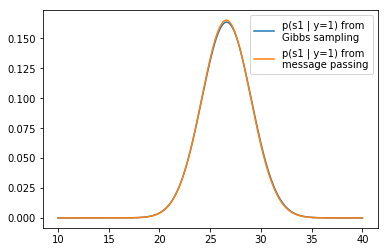

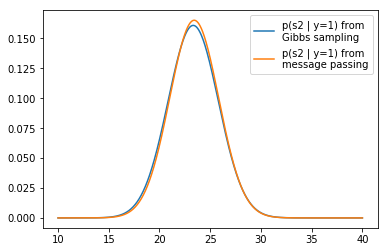

From Gibbs sampling: 
s1_mu= 26.609969387817006 s1_sigma= 5.944622955221686 
s2_mu= 23.322463028736866 s2_sigma= 6.147162881280415
From message passing: 
s1_mu= 26.581909040411844 s1_sigma= 5.830897121196615 
s2_mu= 23.41809095958816 s2_sigma= 5.830897121196615


In [0]:
# Compare posterior from Gibbs sampling with that from Message passing
s1_mu_Gibbs = mu_marg_Gibbs[0]
s1_sigma_Gibbs = cov_marg_Gibbs[0][0]
s2_mu_Gibbs = mu_marg_Gibbs[1]
s2_sigma_Gibbs = cov_marg_Gibbs[1][1]

burn_in = 100
xv = np.linspace(10,40,K-burn_in)
plt.plot(xv, 
          1/np.sqrt(2*np.pi*s1_sigma_Gibbs)*np.exp(-((xv-s1_mu_Gibbs)**2)/2/s1_sigma_Gibbs), 
          label='p(s1 | y=1) from \nGibbs sampling')
plt.plot(xv, 1/np.sqrt(2*np.pi*s1_sigma_MP)*np.exp(-((xv-s1_mu_MP)**2)/2/s1_sigma_MP), 
          label='p(s1 | y=1) from \nmessage passing')
plt.legend(loc='upper right')
plt.show()
plt.plot(xv, 
          1/np.sqrt(2*np.pi*s2_sigma_Gibbs)*np.exp(-((xv-s2_mu_Gibbs)**2)/2/s2_sigma_Gibbs), 
          label='p(s2 | y=1) from \nGibbs sampling')
plt.plot(xv, 1/np.sqrt(2*np.pi*s2_sigma_MP)*np.exp(-((xv-s2_mu_MP)**2)/2/s2_sigma_MP), 
          label='p(s2 | y=1) from \nmessage passing')
plt.legend(loc='upper right')
plt.show()

print("From Gibbs sampling: \ns1_mu=",s1_mu_Gibbs, "s1_sigma=",s1_sigma_Gibbs, 
        "\ns2_mu=",s2_mu_Gibbs, "s2_sigma=",s2_sigma_Gibbs)
print("From message passing: \ns1_mu=",s1_mu_MP, "s1_sigma=",s1_sigma_MP, 
        "\ns2_mu=",s2_mu_MP, "s2_sigma=",s2_sigma_MP)

## Q.9 Our Own Data

In [0]:
new_data = 'ForDownloadOnly/LeagueofLegends.csv'
df_useful_new, df_nodraw_new, draw_num_new = preprocessing_data(new_data, 
                                                                ['blueTeamTag', 'redTeamTag', 'bResult', 'rResult'])
skills_A_new, acc_new = run_games(df_nodraw_new)
print(acc_new)
skills_A_new 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


0.5918367346938775


,TeamName,Mu,Sigma
0,TSM,25.667299,0.031866
1,CLG,25.587352,0.060235
2,TL,25.451693,0.033320
3,TIP,25.395593,0.024118
4,GV,25.358379,0.042900
5,C9,25.333417,0.032168
6,DIG,24.924224,0.071515
7,T8,24.863675,0.086431
8,WFX,24.697300,0.239627
9,TDK,24.333925,0.218330


In [0]:
download_table_latex("newdata.tex",skills_A_new)

## Q.10 Improvement

#### Consider random situation in prediction

In [0]:
def predict_y_random(mu_s1, mu_s2, sigma_s1, sigma_s2, t_sigma=1):
    # Sample one and compare with 0
    sample = np.random.normal(mu_s1-mu_s2, t_sigma+sigma_s1+sigma_s2)
    if(sample>0):
      return 1
    else:
      return -1


def run_games_random(games_df, t_sigma=1, K=1000):  
    #header ["Team1","Team2","Score1","Score2"]
    # Init Dataframe for skill
    all_teams = list(set(games_df["Team1"].tolist()+games_df["Team2"].tolist()))
    pd_skills = pd.DataFrame(columns=["TeamName","Mu","Sigma"], index=all_teams)
    pd_skills["TeamName"] = all_teams
    pd_skills["Mu"] = 25
    pd_skills["Sigma"] = 25/3
    right_pred = 0
    for index, row in games_df.iterrows():
        mu_s1 = pd_skills.loc[row["Team1"],"Mu"]
        sigma_s1 = pd_skills.loc[row["Team1"],"Sigma"]
        mu_s2 = pd_skills.loc[row["Team2"],"Mu"]
        sigma_s2 = pd_skills.loc[row["Team2"],"Sigma"]
        predict_result = predict_y_random(mu_s1, mu_s2, sigma_s1, sigma_s2)
        if(row['result']!=0):
            mu_s1_new, mu_s2_new, sigma_s1_new, sigma_s2_new = end2end_inference(mu_s1, 
                                                                                 sigma_s1, 
                                                                                 mu_s2, 
                                                                                 sigma_s2,
                                                                                 t_sigma,
                                                                                 K,
                                                                                 win=(row['result']>0))
            pd_skills.loc[row["Team1"],"Mu"] = mu_s1_new
            pd_skills.loc[row["Team1"],"Sigma"] = sigma_s1_new
            pd_skills.loc[row["Team2"],"Mu"] = mu_s2_new
            pd_skills.loc[row["Team2"],"Sigma"] = sigma_s2_new
            if(predict_result*row['result']>0):
              right_pred+=1
        else:
            # ==0
            pass
    pd_skill_sort = pd_skills.sort_values("Mu",ascending=False).reset_index(drop = True)
    return pd_skill_sort, right_pred/games_df.shape[0]

In [0]:
np.random.seed(222)
skills_A_random, acc_random = run_games_random(dfA_nodraw)
print("Accuracy: ",acc_random)
skills_A_random

Accuracy:  0.6176470588235294


,TeamName,Mu,Sigma
0,Napoli,26.037812,0.160618
1,Juventus,25.869360,0.193317
2,Milan,25.868687,0.189533
3,Inter,25.812408,0.144040
4,Atalanta,25.633136,0.120824
5,Torino,25.621628,0.165823
6,Roma,25.477402,0.133702
7,Lazio,25.321855,0.130692
8,Spal,25.050932,0.127097
9,Sampdoria,25.013930,0.105489


#### Compare differnet value of `sigma_t`

In [0]:
sigmat_values = [0.5, 1.0, 5.0]
acc_sigmat = np.zeros(3)
for i in range(3):
  st = sigmat_values[i]
  skills_A, acc = run_games(dfA_nodraw, t_sigma=st)
  acc_sigmat[i] = acc
print(acc_sigmat)

[0.63235294 0.64705882 0.61029412]


#### Update model using draw

In [0]:
def run_games_consider_draw(games_df, epsilon=2, t_sigma=1, K=1000):  
    #header ["Team1","Team2","Score1","Score2"]
    # Init Dataframe for skill
    all_teams = list(set(games_df["Team1"].tolist()+games_df["Team2"].tolist()))
    pd_skills = pd.DataFrame(columns=["TeamName","Mu","Sigma"], index=all_teams)
    pd_skills["TeamName"] = all_teams
    pd_skills["Mu"] = 25
    pd_skills["Sigma"] = 25/3
    right_pred = 0
    for index, row in games_df.iterrows():
        mu_s1 = pd_skills.loc[row["Team1"],"Mu"]
        sigma_s1 = pd_skills.loc[row["Team1"],"Sigma"]
        mu_s2 = pd_skills.loc[row["Team2"],"Mu"]
        sigma_s2 = pd_skills.loc[row["Team2"],"Sigma"]
        predict_result = predict_y(mu_s1, mu_s2, sigma_s1, sigma_s2)
        if(row['result']!=0):
            mu_s1_new, mu_s2_new, sigma_s1_new, sigma_s2_new = end2end_inference(mu_s1, 
                                                                                 sigma_s1, 
                                                                                 mu_s2, 
                                                                                 sigma_s2,
                                                                                 t_sigma,
                                                                                 K,
                                                                                 win=(row['result']>0))
            pd_skills.loc[row["Team1"],"Mu"] = mu_s1_new
            pd_skills.loc[row["Team1"],"Sigma"] = sigma_s1_new
            pd_skills.loc[row["Team2"],"Mu"] = mu_s2_new
            pd_skills.loc[row["Team2"],"Sigma"] = sigma_s2_new
            if(predict_result*row['result']>0):
              right_pred+=1
        else:
            # differnece of mu > epsilon
            if_big_diff = abs(mu_s1-mu_s2)>epsilon
            if(if_big_diff):
                mu_s1_new, mu_s2_new, sigma_s1_new, sigma_s2_new = end2end_inference(mu_s1, 
                                                                                 sigma_s1, 
                                                                                 mu_s2, 
                                                                                 sigma_s2,
                                                                                 t_sigma,
                                                                                 K,
                                                                                 win=(mu_s1<mu_s2))
                pd_skills.loc[row["Team1"],"Mu"] = mu_s1_new
                pd_skills.loc[row["Team1"],"Sigma"] = sigma_s1_new
                pd_skills.loc[row["Team2"],"Mu"] = mu_s2_new
                pd_skills.loc[row["Team2"],"Sigma"] = sigma_s2_new
    pd_skill_sort = pd_skills.sort_values("Mu",ascending=False).reset_index(drop = True)
    return pd_skill_sort, right_pred/games_df.shape[0]


In [0]:
# Compare to given data
skills_A_with_draw, acc_A_with_draw = run_games_consider_draw(dfA_useful)
print(acc_A_with_draw)
skills_A_with_draw


0.4763157894736842


,TeamName,Mu,Sigma
0,Juventus,25.789717,0.146313
1,Atalanta,25.575956,0.103717
2,Roma,25.540443,0.142012
3,Napoli,25.465676,0.118858
4,Torino,25.409638,0.126403
5,Milan,25.370399,0.119281
6,Inter,25.349634,0.100768
7,Lazio,25.100471,0.084688
8,Sampdoria,24.875777,0.068568
9,Bologna,24.870109,0.105100


#### Update `sigma_t` for each pair of players

In [0]:
def end2end_inference_sigmat(mu_s1, var_s1, mu_s2, var_s2, t_sigma, K, win=True):
    s_mean = np.mat([[mu_s1], [mu_s2]])
    s_sigma = np.mat([[var_s1, 0], [0, var_s2]])
    t_sigma = 1
    s1, s2, t = GibbsSampling(s_mean, s_sigma, t_sigma, K, win)
    mu_marg, cov_marg = calcu_marg_para(s1,s2,t,K)
    #print("mean: ", mu_marg, "\ncovariance: \n", cov_marg)
    return mu_marg, cov_marg

    
def run_games_sigmat(games_df, epsilon=2, t_sigma_init=1, K=1000):  
    #header ["Team1","Team2","Score1","Score2"]
    # Init Dataframe for skill
    all_teams = list(set(games_df["Team1"].tolist()+games_df["Team2"].tolist()))
    pd_skills = pd.DataFrame(columns=["TeamName","Mu","Sigma"], index=all_teams)
    pd_skills["TeamName"] = all_teams
    pd_skills["Mu"] = 25
    pd_skills["Sigma"] = 25/3
    pd_sigmat = pd.DataFrame(data=t_sigma_init, columns=all_teams, index=all_teams)
    right_pred = 0
    for index, row in games_df.iterrows():
        mu_s1 = pd_skills.loc[row["Team1"],"Mu"]
        sigma_s1 = pd_skills.loc[row["Team1"],"Sigma"]
        mu_s2 = pd_skills.loc[row["Team2"],"Mu"]
        sigma_s2 = pd_skills.loc[row["Team2"],"Sigma"]
        t_sigma = pd_sigmat.loc[row["Team1"],row["Team2"]]
        predict_result = predict_y(mu_s1, mu_s2, sigma_s1, sigma_s2)
        if(row['result']!=0):
            mu_matrix, cov_matrix = end2end_inference_sigmat(mu_s1, sigma_s1, 
                                                             mu_s2, sigma_s2,
                                                             t_sigma, K, win=(row['result']>0))
            pd_skills.loc[row["Team1"],"Mu"] = mu_matrix[0]
            pd_skills.loc[row["Team1"],"Sigma"] = cov_matrix[0][0]
            pd_skills.loc[row["Team2"],"Mu"] = mu_matrix[1]
            pd_skills.loc[row["Team2"],"Sigma"] = cov_matrix[1][1]
            pd_sigmat.loc[row["Team1"],row["Team2"]] = cov_matrix[2][2]
            pd_sigmat.loc[row["Team2"],row["Team1"]] = cov_matrix[2][2]
            if(predict_result*row['result']>0):
              right_pred+=1
        else:
            # ==0
            pass
    pd_skill_sort = pd_skills.sort_values("Mu",ascending=False).reset_index(drop = True)
    return pd_skill_sort, right_pred/games_df.shape[0]


In [0]:
# Compare to SeririeA
skills_A_sigmat, acc_A_sigmat = run_games_sigmat(dfA_useful)
print(acc_A_sigmat)
skills_A_sigmat

0.4631578947368421


,TeamName,Mu,Sigma
0,Napoli,25.982543,0.179840
1,Milan,25.885313,0.210123
2,Atalanta,25.724481,0.128831
3,Juventus,25.666731,0.239968
4,Torino,25.586058,0.144900
5,Inter,25.584053,0.171527
6,Roma,25.309985,0.141081
7,Lazio,25.090413,0.116587
8,Sampdoria,24.929276,0.111203
9,Spal,24.854391,0.134339
